## 0.0 Import Relevant Libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
else:
    device = torch.device("cpu")
print(f"Using {device} as device")


Using cuda as device


In [2]:



data_dir = 'data/'



train_features = pd.read_csv(data_dir+"train_features.csv", index_col="id")
test_features = pd.read_csv(data_dir+"test_features.csv", index_col="id")
train_labels = pd.read_csv(data_dir+"train_labels.csv", index_col="id")

In [3]:
train_features.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


In [4]:
train_features = pd.read_csv(data_dir+"train_features.csv", index_col="id")
train_features['filepath'] = data_dir+train_features['filepath']
train_features.head()

,filepath,site
id,,
ZJ000000,data/train_features/ZJ000000.jpg,S0120
ZJ000001,data/train_features/ZJ000001.jpg,S0069
ZJ000002,data/train_features/ZJ000002.jpg,S0009
ZJ000003,data/train_features/ZJ000003.jpg,S0008
ZJ000004,data/train_features/ZJ000004.jpg,S0036


In [5]:
test_features.head()

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040


In [6]:
test_features = pd.read_csv(data_dir+"test_features.csv", index_col="id")
test_features['filepath'] = data_dir+test_features['filepath']
test_features.head()

,filepath,site
id,,
ZJ016488,data/test_features/ZJ016488.jpg,S0082
ZJ016489,data/test_features/ZJ016489.jpg,S0040
ZJ016490,data/test_features/ZJ016490.jpg,S0040
ZJ016491,data/test_features/ZJ016491.jpg,S0041
ZJ016492,data/test_features/ZJ016492.jpg,S0040


In [7]:
train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

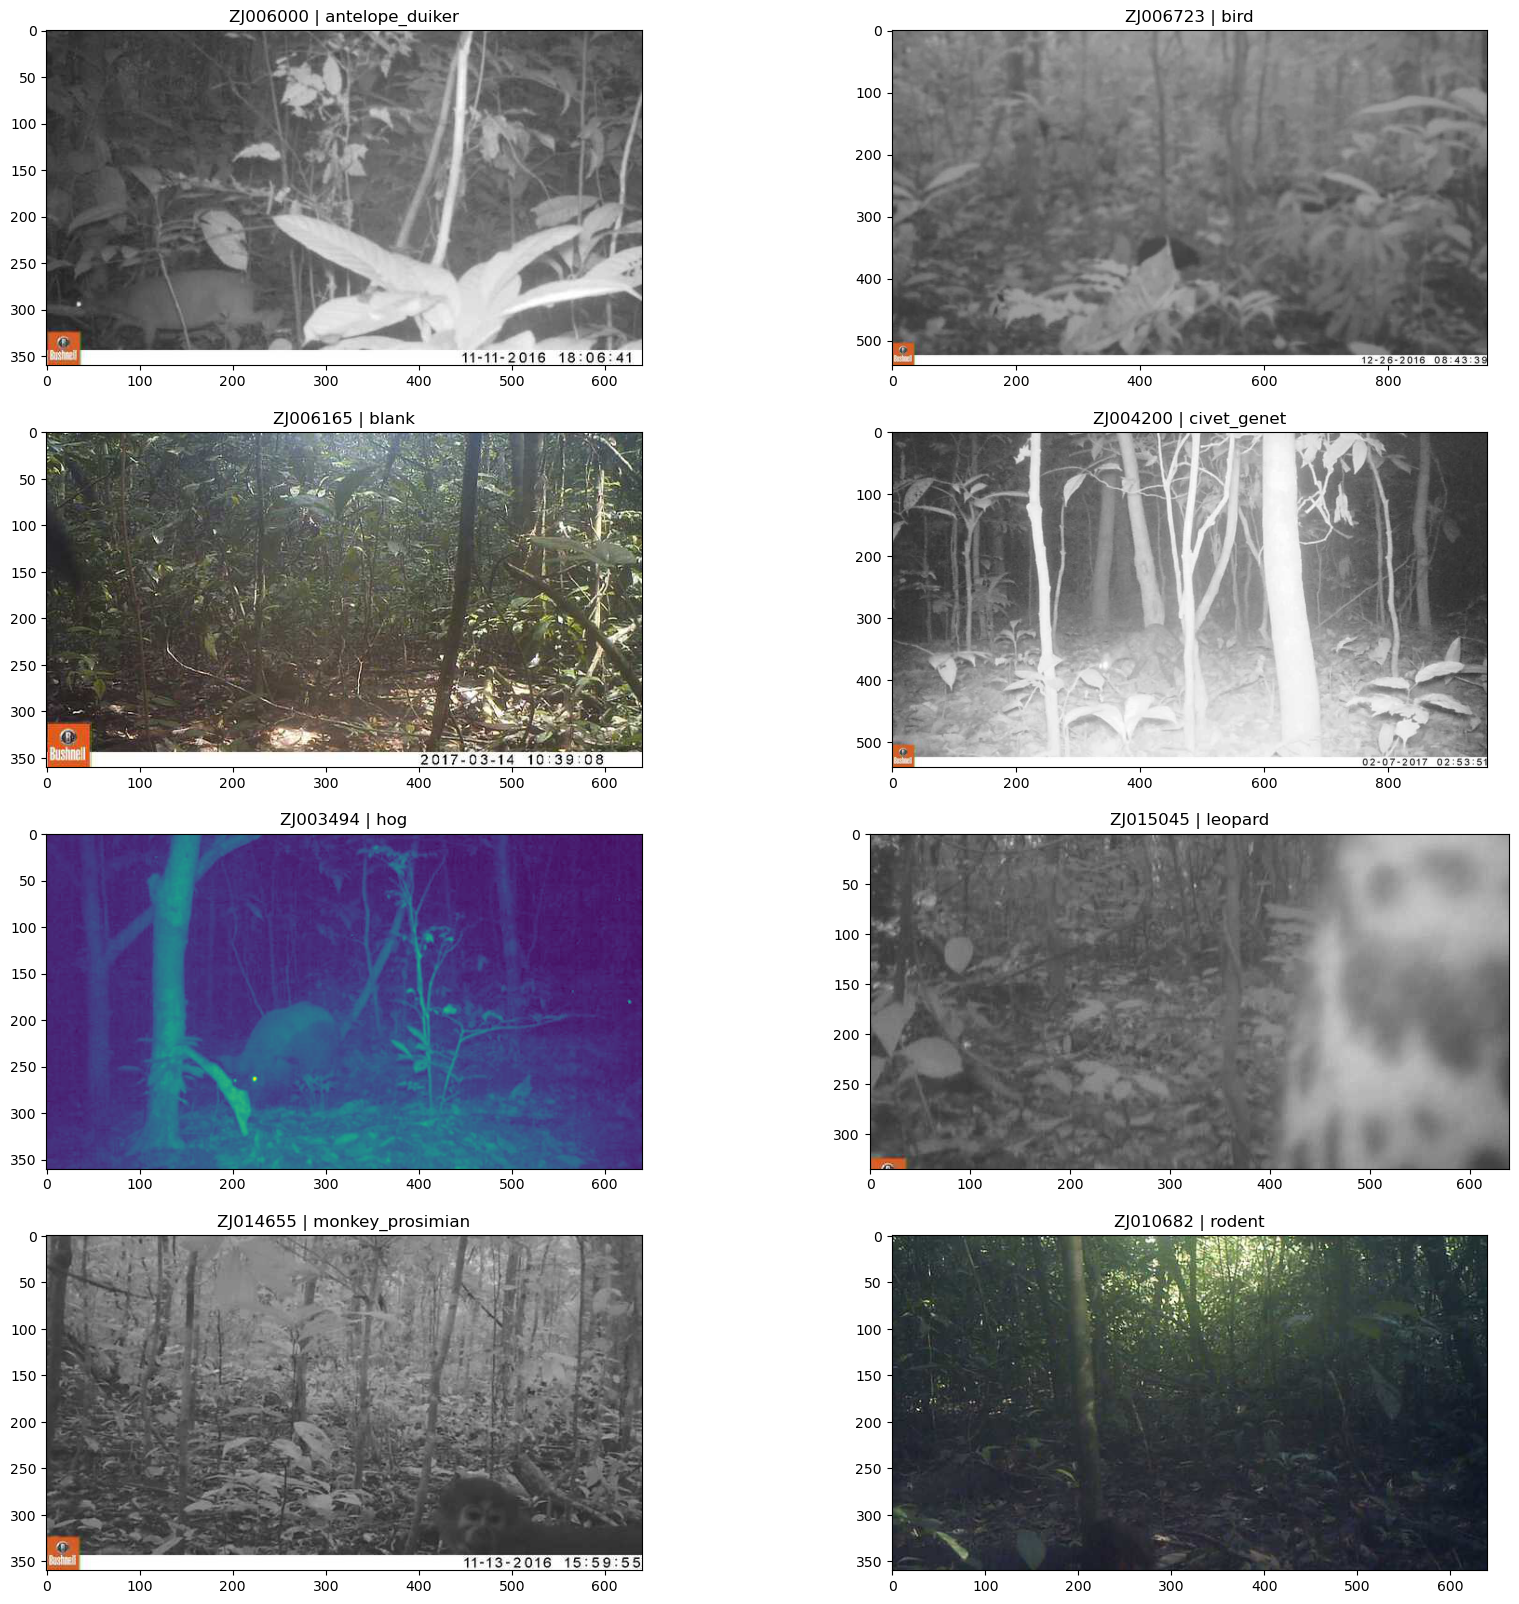

In [9]:
random_state = 42

# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

In [10]:
# import torch
from torch.utils.data import Dataset
from torchvision import transforms



In [11]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

In [12]:
class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [13]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

monkey_prosimian    0.151140
antelope_duiker     0.150049
civet_genet         0.146955
leopard             0.136705
blank               0.134219
rodent              0.122089
bird                0.099527
hog                 0.059316
dtype: float64

In [14]:
from sklearn.model_selection import train_test_split

frac = 0.5
TEST_RATIO = 0.2


y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_test, y_train, y_test = train_test_split(
    x, y, stratify=y, test_size=TEST_RATIO
)





# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, stratify=y_train, test_size=TEST_RATIO
)
print(len(x),len(y))
print(len(x_test),len(y_test))
print(len(x_train),len(y_train))
print(len(x_val),len(y_val))

8244 8244
1649 1649
5276 5276
1319 1319


In [15]:
y

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000625,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ008571,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ008106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ZJ011175,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ003323,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
ZJ011309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ014688,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ002772,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
dataset_train = ImagesDataset(x_train, y_train)
dataset_test = ImagesDataset(x_test,y_test)
dataset_val = ImagesDataset(x_val,y_val)
num_workers = 0
loaders = {
    'train' : torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=num_workers),
    
    'test'  : torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=num_workers),
    'val'  : torch.utils.data.DataLoader(dataset_val, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=num_workers),
}

In [17]:
from torch.utils.data import DataLoader

train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32)

In [18]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "val": y_val.idxmax(axis=1).value_counts(normalize=True),
        "test": y_test.idxmax(axis=1).value_counts(normalize=True)
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


,train,val,test
monkey_prosimian,15,15,15
antelope_duiker,14,14,14
civet_genet,14,14,14
blank,13,13,13
leopard,13,13,13
rodent,11,11,11
bird,9,9,9
hog,5,5,5


In [19]:
from torch.utils.data import DataLoader




train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32)

In [20]:
len(train_dataloader)

165

In [21]:
len(loaders['train'])

165

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader

from torch import optim
import torch.nn as nn
from torch.nn import Module
import torchvision.models as models
import torch.nn.functional as F

import pandas as pd
from numpy import mean
import datetime
import timeit
from copy import deepcopy

## 1.2 Define some Helper Functions 

All of the helper functions defined below were taken from previous notebooks provided by the professor and slightly modified to meet the requirements for this problem.

### 1.2.1 Define a funciton for the training loop

In [23]:
def TRAIN_LOOP(loader_train, model, loss_func, optimizer, device,calculating_accuracy=True):
    model.train()
    size = len(loader_train.dataset)
    losses_train = []
    steps = []
    if calculating_accuracy:
        accuracies_epoch = []
    
    for i, data in tqdm(enumerate(loader_train, 0),total=len(loader_train)):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data["image"]
        labels = data["label"]
        
         # a CUDA device object
        inputs = inputs.to(device)
        labels = (np.argmax(labels.cpu(),axis=1)).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        
        current = i * len(labels)
        
        loss = loss.item()
        # Compute accuracy without affecting the gradients        
        

        losses_train.append(loss)
        steps.append(current)    
        if calculating_accuracy:
            with torch.no_grad():
                accuracy_batch = (outputs.argmax(1) == labels).type(torch.float).sum().item()/len(labels)
            accuracies_epoch.append(accuracy_batch)
    if not calculating_accuracy:
            return losses_train, [], steps
    return losses_train, accuracies_epoch, steps
            
# Create an instance of TRAIN_LOOP
train_loop = TRAIN_LOOP

### 1.2.2 Define a function for the test loop

In [24]:
@torch.no_grad()
def TEST_LOOP(loader_val, model, loss_fn,device, method="Test",calculating_accuracy=True):
    
    model.eval()
    size = len(loader_val.dataset)
    num_batches = len(loader_val)
    test_loss = 0
    if calculating_accuracy:
        correct = 0

    for i, data in enumerate(loader_val,0):
        X = data["image"].to(device)
        y = (np.argmax(data["label"].cpu(),axis=1)).to(device)

        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        if calculating_accuracy:
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    if not calculating_accuracy:
        print(f"{method} Avg loss: {test_loss:>8f} \n")
        return -1, test_loss
    correct /= size
    print(f"{method} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

# Initiate an instance of TEST_LOOP
test_loop = TEST_LOOP

### 1.2.3 Define our training function to train and validate our model

The function below has not only been modified from class notebooks to fit this problem but also to keep track of the best performing model in terms of validation accuracy and saving it so that we can use it for testing. 

In [25]:
def train(model, num_epochs, loss_function, optimizer, dataloader_train, dataloader_valid,device,model_name,calculating_accuracy=True):
    losses_train_all_epochs = []
    accuracies_train_all_epochs = []
    steps_all_epochs = []
    accuracies_val_all_epochs = []
    losses_val_all_epochs = []
    best_acc = -5
    
    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        losses_train, accuracies_epoch, steps = train_loop(dataloader_train, model, loss_function, optimizer,device,calculating_accuracy=calculating_accuracy)
        losses_train_all_epochs.append(losses_train)
        accuracies_train_all_epochs.append(accuracies_epoch)
        steps_all_epochs.append(steps)

        accuracy_val, loss_val = test_loop(dataloader_valid, model, loss_function,device=device, method="Valid", calculating_accuracy=calculating_accuracy)
        accuracies_val_all_epochs.append(accuracy_val)
        losses_val_all_epochs.append(loss_val)
        
        if accuracy_val > best_acc:
            best_acc = accuracy_val
            best_state = deepcopy(model.state_dict())
            torch.save(best_state,f"{model_name}.pt")
        print(f"Best Model Accuracy: {round(best_acc,4)*100}%")    
    print("Done!")
    return accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs

### 1.2.4 Define a function to plot model performance during training

In [26]:
def plot_history(accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs, method='mean'):
    if method == 'mean':
        accuracies_train = [mean(accuracies_train_per_epoch) for accuracies_train_per_epoch in accuracies_train_all_epochs]
        losses_train = [mean(losses_train_per_epoch) for losses_train_per_epoch in losses_train_all_epochs]
    elif method == 'end':
        accuracies_train = [accuracies_train_per_epoch[-1] for accuracies_train_per_epoch in accuracies_train_all_epochs]
        losses_train = [losses_train_per_epoch[-1] for losses_train_per_epoch in losses_train_all_epochs]

    df_runs = pd.DataFrame({
        'accuracy_train': accuracies_train,
        'accuracy_valid': accuracies_val_all_epochs,
        'loss_train': losses_train,
        'loss_valid': losses_val_all_epochs,
    })

    df_runs.plot(figsize=(14, 10))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

## 1.3 Define my own helper functions
### 1.3.1 Define a function to measure model accuracy on the test dataset

In [27]:
def model_accuracy(model,test_loader):
    model.eval()
    

    model = model.to(device)
    pred_list = []
    true_list = []
    
    for i, data in enumerate(test_loader,0):
        # Move the batch to the device
        batch_imgs = data["image"].to(device)
        batch_labels = (np.argmax(data["label"].cpu(),axis=1)).to(device)


        # Pass the batch through the model to get the predicted labels
        output = model(batch_imgs)

        y_pred = torch.max(output, 1)[1]


        # Append the predicted and true labels to the lists
        pred_list.append(y_pred.cpu().numpy())
        true_list.append(batch_labels.cpu().numpy())   

    # Concatenate the predicted and true labels
    pred_array = np.concatenate(pred_list)
    true_array = np.concatenate(true_list)

    # Calculate the overall accuracy
    acc = accuracy_score(true_array, pred_array)
    return acc

# <center>RUN 1</center>

### 1.3.2 Function to determine whether we are finetuning a model or feature extracting.
This function was taken from the `PyTorch` documentation. 

In [28]:
def set_parameter_requires_grad(model, requires_grad):
    if not requires_grad:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True

In [29]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")          # a CUDA device object
# else:
#     device = torch.device("cpu")
# print(f"Using {device} as device")
device = 'cuda'

In [30]:
base_model = models.shufflenet_v2_x0_5(weights='DEFAULT')


class MyCNN1(Module):
    
    def __init__(self,num_classes= 18):
        super().__init__()
        # Load the pre-trained shufflenet model
        self.base_model = base_model
        

        self.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        return x

## 2.1.1 Initialize Important Parameters for our model training

In [31]:
num_epochs = 1
lr = 1e-3
model = MyCNN1().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)  
loss_func = nn.CrossEntropyLoss()   

## 2.1.2 Train the model

Train the model using the CNN defined above along with the parameters defined above

In [32]:
print(f"Using {device} as device.\n\n-------------------------------")
start = timeit.default_timer()
start = timeit.default_timer()
accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs = train(model, 
                                                                                                               num_epochs, 
                                                                                                               loss_func, 
                                                                                                               optimizer, 
                                                                                                               loaders['train'], 
                                                                                                               loaders['val'],
                                                                                                               device,
                                                                                                               model_name='model1_state')

MODEL1 = deepcopy(MyCNN1())
# MODEL1.load_state_dict(torch.load('model1_state.pt'))
stop = timeit.default_timer()
runtime = datetime.timedelta(seconds=stop-start)
hours = runtime.seconds//3600
minutes = (runtime.seconds - 3600*hours) //60
seconds = runtime.seconds - minutes*60 - hours*3600
print(f'\n\n\nRuntime: {hours}h {minutes}m {seconds}s')

Using cuda as device.

-------------------------------
Epoch 1
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [00:46<00:00,  3.56it/s]


Valid Error: 
 Accuracy: 63.8%, Avg loss: 1.156508 

Best Model Accuracy: 63.75999999999999%
Done!



Runtime: 0h 0m 56s


In [33]:
model1_accuracy_best = model_accuracy(MODEL1,loaders['test'])
print(f"Model 1 Accuracy was :{round(model1_accuracy_best*100,1)}%")

Model 1 Accuracy was :62.7%


In [34]:
model1_accuracy_last = model_accuracy(model,loaders['test'])
print(f"Model 1 Accuracy was :{round(model1_accuracy_last*100,1)}%")

Model 1 Accuracy was :62.7%


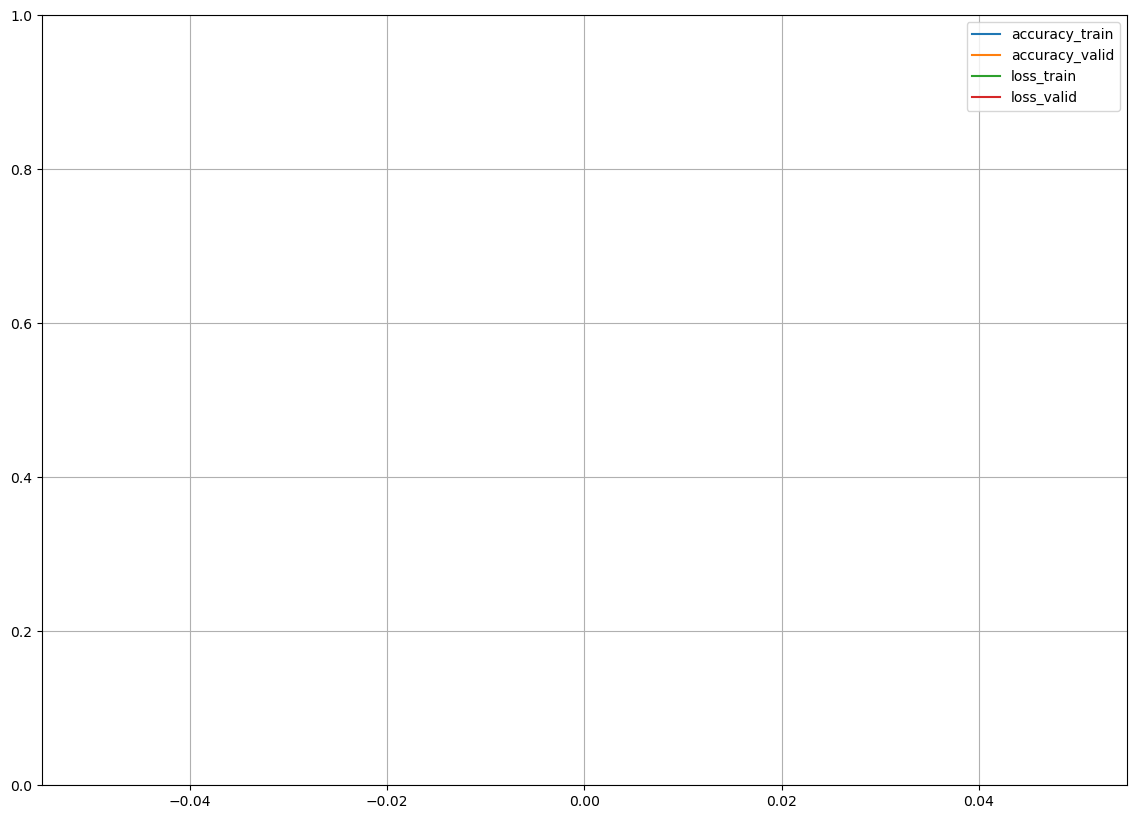

In [35]:
plot_history(accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs)

# <center>RUN 2 </center>

In [36]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")          # a CUDA device object
# else:
#     device = torch.device("cpu")
# print(f"Using {device} as device")
device = 'cpu'

In [37]:
base_model = models.shufflenet_v2_x0_5(weights='DEFAULT')


class MyCNN1(Module):
    
    def __init__(self,num_classes= 18):
        super().__init__()
        # Load the pre-trained shufflenet model
        self.base_model = base_model
        

        self.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        return x

## 2.1.1 Initialize Important Parameters for our model training

In [38]:
num_epochs = 1


lr = 1e-3
model = MyCNN1().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)  
loss_func = nn.CrossEntropyLoss()   

## 2.1.2 Train the model

Train the model using the CNN defined above along with the parameters defined above

In [39]:
print(f"Using {device} as device.\n\n-------------------------------")
start = timeit.default_timer()
start = timeit.default_timer()
accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs = train(model, 
                                                                                                               num_epochs, 
                                                                                                               loss_func, 
                                                                                                               optimizer, 
                                                                                                               loaders['train'], 
                                                                                                               loaders['val'],
                                                                                                               device,
                                                                                                               model_name='model1_state')

MODEL1 = deepcopy(MyCNN1())
# MODEL1.load_state_dict(torch.load('model1_state.pt'))
stop = timeit.default_timer()
runtime = datetime.timedelta(seconds=stop-start)
hours = runtime.seconds//3600
minutes = (runtime.seconds - 3600*hours) //60
seconds = runtime.seconds - minutes*60 - hours*3600
print(f'\n\n\nRuntime: {hours}h {minutes}m {seconds}s')

Using cpu as device.

-------------------------------
Epoch 1
-------------------------------


  8%|██████▊                                                                          | 14/165 [00:10<01:57,  1.29it/s]


KeyboardInterrupt: 

In [ ]:
model1_accuracy_best = model_accuracy(MODEL1,loaders['test'])
print(f"Model 1 Accuracy was :{round(model1_accuracy_best*100,1)}%")

In [ ]:
model1_accuracy_last = model_accuracy(model,loaders['test'])
print(f"Model 1 Accuracy was :{round(model1_accuracy_last*100,1)}%")

In [ ]:
plot_history(accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs)

# <center>RUN 3 </center>

In [ ]:
dataset_train = ImagesDataset(x_train, y_train)
dataset_test = ImagesDataset(x_test,y_test)
dataset_val = ImagesDataset(x_val,y_val)
num_workers = 14
loaders = {
    'train' : torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=num_workers),
    
    'test'  : torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=num_workers),
    'val'  : torch.utils.data.DataLoader(dataset_val, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=num_workers),
}

In [ ]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")          # a CUDA device object
# else:
#     device = torch.device("cpu")
# print(f"Using {device} as device")
device = 'cuda'

In [ ]:
base_model = models.shufflenet_v2_x0_5(weights='DEFAULT')


class MyCNN1(Module):
    
    def __init__(self,num_classes= 18):
        super().__init__()
        # Load the pre-trained shufflenet model
        self.base_model = base_model
        

        self.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        return x

## 2.1.1 Initialize Important Parameters for our model training

In [ ]:
num_epochs = 1
lr = 1e-3
model = MyCNN1().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)  
loss_func = nn.CrossEntropyLoss()   

## 2.1.2 Train the model

Train the model using the CNN defined above along with the parameters defined above

In [ ]:
print(f"Using {device} as device.\n\n-------------------------------")
start = timeit.default_timer()
start = timeit.default_timer()
accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs = train(model, 
                                                                                                               num_epochs, 
                                                                                                               loss_func, 
                                                                                                               optimizer, 
                                                                                                               loaders['train'], 
                                                                                                               loaders['val'],
                                                                                                               device,
                                                                                                               model_name='model1_state')

MODEL1 = deepcopy(MyCNN1())
# MODEL1.load_state_dict(torch.load('model1_state.pt'))
stop = timeit.default_timer()
runtime = datetime.timedelta(seconds=stop-start)
hours = runtime.seconds//3600
minutes = (runtime.seconds - 3600*hours) //60
seconds = runtime.seconds - minutes*60 - hours*3600
print(f'\n\n\nRuntime: {hours}h {minutes}m {seconds}s')

In [ ]:
model1_accuracy_best = model_accuracy(MODEL1,loaders['test'])
print(f"Model 1 Accuracy was :{round(model1_accuracy_best*100,1)}%")

In [ ]:
model1_accuracy_last = model_accuracy(model,loaders['test'])
print(f"Model 1 Accuracy was :{round(model1_accuracy_last*100,1)}%")

In [ ]:
plot_history(accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs)